# Prova de Conceito (Versão Notebook)

Enviar a requisição pra API

In [105]:
import requests
import os
import plotly.express as px
from datetime import datetime
from datetime import timedelta
from dateutil import relativedelta

# Request Setup
url = 'https://api.tecsus.com.br/v0/smartmeter/get_simple_data'
headers = {'x-api-key': os.environ['TECSUS_API_KEY']}
params = {'device_id': '198762435721298897478401',
           'dt_start': '2021-08-01 00:00:00',
           'dt_end': '2021-08-30 00:00:00'}


# Send request
r = requests.get(url, headers=headers, params=params)
data = r.json()

if data == None or data['error']:
    print('Request Error')
    exit

Processar o resultado

In [73]:
raw_measures = data['data'][0]['measures']
measures = []
measures_time = []
measures_accumulated = []

for raw_measure in raw_measures:
    measures.append(raw_measure['measure'])
    measures_time.append(datetime.fromtimestamp(raw_measure['measure_unixtime']))
    measures_accumulated.append(raw_measure['measure_accumulated'])

Gráfico

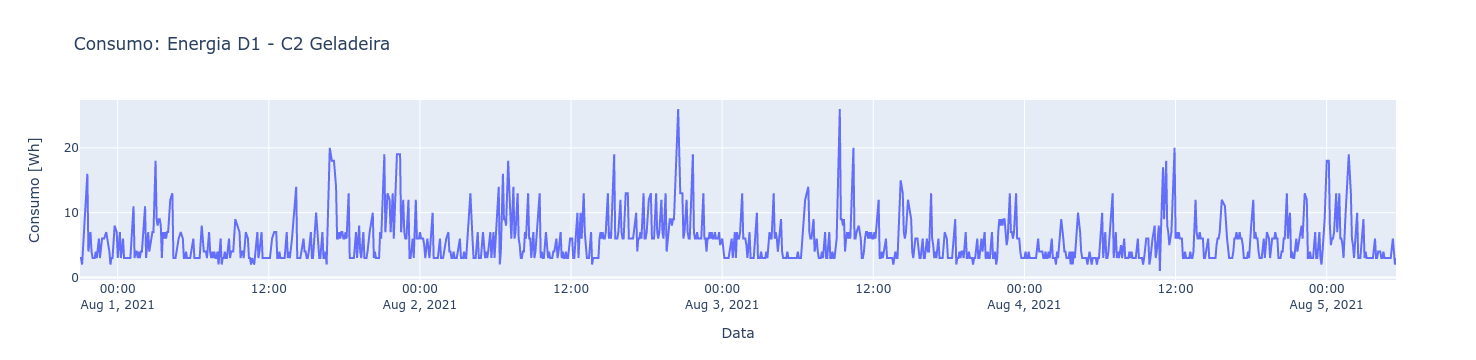

In [74]:
fig = px.line(x=measures_time, y=measures, title=f'Consumo: {data["device_name"]}')
fig.update_xaxes(title="Data")
fig.update_yaxes(title="Consumo [Wh]")
fig.show()

Suavizando Intervalos (para o consumo ficar mais constante)

In [75]:
measures_smooth = []
measures_time_smooth = []
measures_accumulated_smooth = []

measures_smooth.append(measures[0])
measures_time_smooth.append(measures_time[0])
measures_accumulated_smooth.append(measures_accumulated[0])

for i in range(1,len(measures)):
    delta_time_minutes = round((measures_time[i] - measures_time[i-1]).total_seconds() / 60)
    
    if delta_time_minutes > 5:
        multiplier = round(delta_time_minutes / 5)
        for j in range(multiplier):
            measures_smooth.append(measures[i] / multiplier)
            measures_time_smooth.append(measures_time[i-1] + timedelta(minutes=(j+1)*5))
        pass
    else:
        measures_smooth.append(measures[i])
        measures_time_smooth.append(measures_time[i])

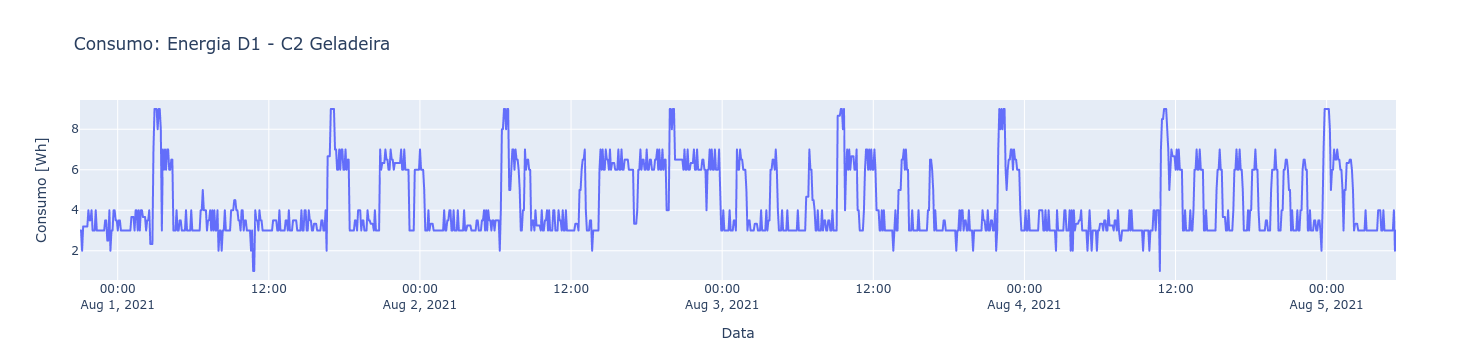

In [76]:
fig = px.line(x=measures_time_smooth, y=measures_smooth, title=f'Consumo: {data["device_name"]}')
fig.update_xaxes(title="Data")
fig.update_yaxes(title="Consumo [Wh]")
fig.show()

Média Móvel

In [77]:
mm_range = 10
measures_mm = []
for idx in range(len(measures_smooth) - mm_range):
    measures_range = measures_smooth[idx:idx+mm_range]
    #print(f'{measures_range} - {len(measures_range)}')
    measures_mm.append( sum(measures_range) / len(measures_range) )
measures_time_mm = measures_time_smooth[mm_range:]

Gráfico

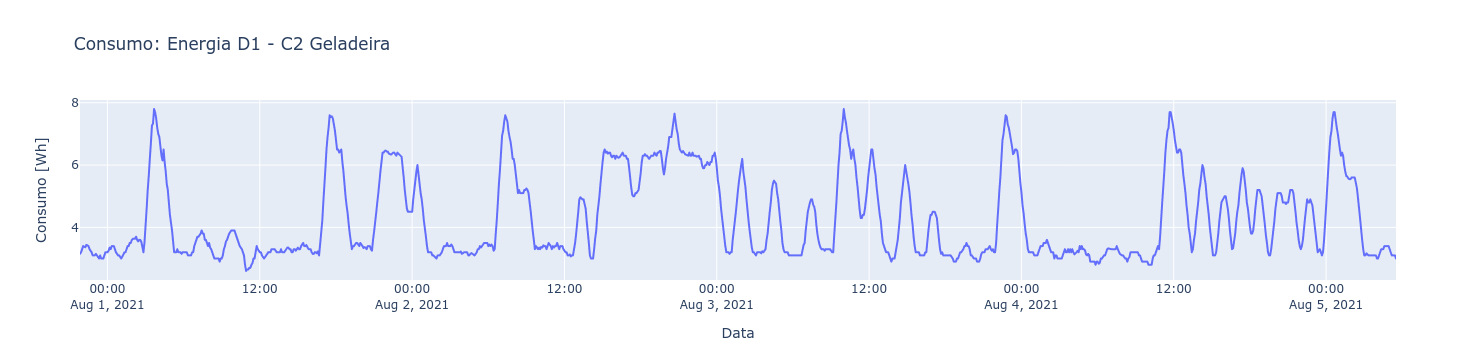

In [78]:
fig = px.line(x=measures_time_mm, y=measures_mm, title=f'Consumo: {data["device_name"]}')
fig.update_xaxes(title="Data")
fig.update_yaxes(title="Consumo [Wh]")
fig.show()

## Brincando com datetime

In [79]:
now = datetime.now()

today = datetime.today()
first_day_month = today.replace(day=1)

In [80]:
# params = {
#     'device_id': '198762435721298897478401',
#     'dt_start': '2021-10-01 00:00:00',
#     'dt_end': '2021-10-30 00:00:00'
# }

today.strftime('%Y-%m-%d %H:%M:%S')

'2021-11-21 22:33:46'

## Quebrando um range de datas em ranges menores (multiplos requests)

In [81]:
MAX_DAYS_REQUEST = 3

date_format_str = '%Y-%m-%d %H:%M:%S'
today = datetime.today()
first_day_month = today.replace(day=1)

start_date = first_day_month
end_date = today

params_array = []

delta_days = round((end_date - start_date).total_seconds() / (3600 * 24))
if delta_days > MAX_DAYS_REQUEST:
    temp_start_date = start_date
    temp_end_date = start_date + timedelta(days=MAX_DAYS_REQUEST)
    while temp_end_date < end_date:
        params_array.append({
            'device_id': '198762435721298897478401',
            'dt_start': temp_start_date.strftime(date_format_str),
            'dt_end': temp_end_date.strftime(date_format_str)
        })
        temp_start_date = temp_end_date + timedelta(seconds=1)
        temp_end_date += timedelta(days=MAX_DAYS_REQUEST)
    
    temp_end_date -= timedelta(days=MAX_DAYS_REQUEST)
    temp_end_date += timedelta(seconds=1)
    params_array.append({
        'device_id': '198762435721298897478401',
        'dt_start': temp_end_date.strftime(date_format_str),
        'dt_end': end_date.strftime(date_format_str)
    })
else:
    params_array.append({
        'device_id': '198762435721298897478401',
        'dt_start': start_date.strftime(date_format_str),
        'dt_end': end_date.strftime(date_format_str)
    })
        
# params = {
#     'device_id': '198762435721298897478401',
#     'dt_start': start_date.strftime(date_format_str),
#     'dt_end': end_date.strftime(date_format_str)
# }

In [82]:
params_array

[{'device_id': '198762435721298897478401',
  'dt_start': '2021-11-01 22:33:47',
  'dt_end': '2021-11-04 22:33:47'},
 {'device_id': '198762435721298897478401',
  'dt_start': '2021-11-04 22:33:48',
  'dt_end': '2021-11-07 22:33:47'},
 {'device_id': '198762435721298897478401',
  'dt_start': '2021-11-07 22:33:48',
  'dt_end': '2021-11-10 22:33:47'},
 {'device_id': '198762435721298897478401',
  'dt_start': '2021-11-10 22:33:48',
  'dt_end': '2021-11-13 22:33:47'},
 {'device_id': '198762435721298897478401',
  'dt_start': '2021-11-13 22:33:48',
  'dt_end': '2021-11-16 22:33:47'},
 {'device_id': '198762435721298897478401',
  'dt_start': '2021-11-16 22:33:48',
  'dt_end': '2021-11-19 22:33:47'},
 {'device_id': '198762435721298897478401',
  'dt_start': '2021-11-19 22:33:48',
  'dt_end': '2021-11-21 22:33:47'}]

In [90]:
measures = []
measures_time = []
measures_accumulated = []

for params in params_array:
    # Send request
    r = requests.get(url, headers=headers, params=params)
    data = r.json()
    raw_measures = data['data'][0]['measures']
    for raw_measure in raw_measures:
        measures.append(raw_measure['measure'])
        measures_time.append(datetime.fromtimestamp(raw_measure['measure_unixtime']))
        measures_accumulated.append(raw_measure['measure_accumulated'])
        
measures_smooth = []
measures_time_smooth = []
measures_accumulated_smooth = []

measures_smooth.append(measures[0])
measures_time_smooth.append(measures_time[0])
measures_accumulated_smooth.append(measures_accumulated[0])

for i in range(1,len(measures)):
    delta_time_minutes = round((measures_time[i] - measures_time[i-1]).total_seconds() / 60)
    
    if delta_time_minutes > 5:
        multiplier = round(delta_time_minutes / 5)
        for j in range(multiplier):
            measures_smooth.append(measures[i] / multiplier)
            measures_time_smooth.append(measures_time[i-1] + timedelta(minutes=(j+1)*5))
        pass
    else:
        measures_smooth.append(measures[i])
        measures_time_smooth.append(measures_time[i])

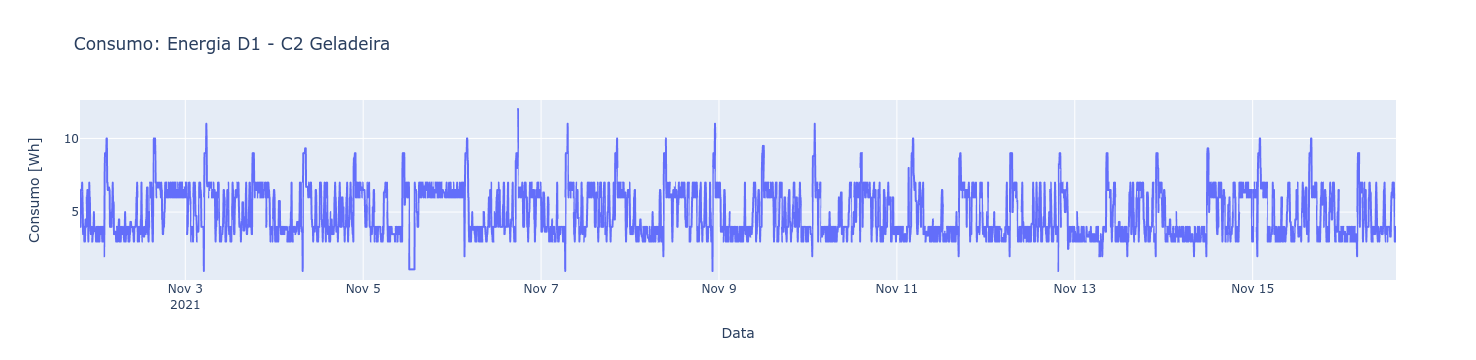

In [91]:
# Creating DataFrame

fig = px.line(x=measures_time, y=measures, title=f'Consumo: {data["device_name"]}')
fig = px.line(x=measures_time_smooth, y=measures_smooth, title=f'Consumo: {data["device_name"]}')
fig.update_xaxes(title="Data")
fig.update_yaxes(title="Consumo [Wh]")
fig.show()

In [92]:
def seleciona_tarifa(hours, minutes):
    total_minutes = hours*60 + minutes
    
    if total_minutes <= 16*60 + 30 or total_minutes >= 21*60 + 30:
        return 'ponta'
    elif total_minutes <= 17*60 + 30 or total_minutes >= 20*60 + 30:
        return 'intermediario'
    else:
        return 'foraponta'

def custo_convencional(measures, measures_time):
    # Tarifa normal (fácil de calcular)
    taxa = 0.636
    custo = 0
    consumo = 0
    for i in range(len(measures)):
        consumo += measures[i] / 1000
        custo += measures[i] / 1000 * taxa
    
    return (consumo, custo)

def custo_tarifa_branca(measures, measures_time):
    # Tarifa branca (mais suga)
    taxa = {}
    taxa['ponta'] = 0.512
    taxa['intermediario'] = 0.721
    taxa['foraponta'] = 1.113

    custo = 0
    consumo = 0
    for i in range(len(measures)):
        tarifa = seleciona_tarifa(measures_time[i].minute, measures_time[i].hour)
        consumo += measures[i] / 1000
        custo += measures[i] / 1000 * taxa[tarifa]
    
    return (consumo, custo)

In [93]:
(consumo, custo) = custo_convencional(measures, measures_time)
print(f'[Tarifa Convencional] Consumo: {consumo:.2f} kWh = R${custo:.2f}')

(consumo, custo) = custo_tarifa_branca(measures, measures_time)
print(f'[Tarifa Branca] Consumo: {consumo:.2f} kWh = R${custo:.2f}')

[Tarifa Convencional] Consumo: 21.00 kWh = R$13.36
[Tarifa Branca] Consumo: 21.00 kWh = R$11.74


In [107]:
datetime.today() - relativedelta.relativedelta(months=3)

datetime.datetime(2021, 8, 21, 23, 38, 21, 985551)